# Analysis of Model

Here, we load the weights of a fully trained model of the Gaussian beam propagation in order to do graphics and other stuff.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from time import time

In [2]:
save_to_thesis = True

In [3]:
boundary_condition = 'dirichlet'

In [4]:
folder = f'/home/jakob/OneDrive/Physik/SemesterVI/ThesisTeX/graphics/chapter4_waveguide'

In [5]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

In [6]:
tf.random.set_seed(42) # always the same seed - reproducibility

In [7]:
pi = tf.constant(np.pi, dtype=DTYPE) # everybody needs some pi in their life

2022-07-01 14:51:45.626715: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-01 14:51:45.627037: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-01 14:51:45.628305: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
plt.style.use('rc.mplstyle')

In [9]:
plt.rcParams['axes.grid'] = False   # otherwise he dislikes colorplots

### parameters

In [10]:
number = 11

In [11]:
with open(f'documentation/calc{number}.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        print(line)

Documentation for Calculation 11

Waveguide, normalized

Boundary condition: dirichlet

Optimizer: Adam till 12000, L-BFGS from 12000 to 20000

5 Layers and 32 nodes per layer

Learning rate is 0.001, residual weights is 0.0005

Bound weight is 1.0 and initial weight is 1.0

Highest n in initial wave is 2

Coefficients are [1.+1.j 1.+1.j] (unnormalized)

a = 1.0 and n_0 = 1.0

x_lb = -1 and x_ub = 1

z_lb = 0.0 and z_ub = 1

N = 10000 and N_test = 101 and N_b / N_0 = 200


In [12]:
k_0 = 1.
n_0 = 1.
a = 1.
limit = 2

x_lb = -1.
x_ub = 1.

if number == 10:
    x_lb = -1.5
    x_ub = 1.5

z_lb = 0.
z_ub = 1.

coeff_pre = np.zeros(limit).astype(np.complex64)
coeff_pre[0] = 1 +1j
coeff_pre[1] = 1 + 1j
#coeff_pre[2] = .75 + .5j
#coeff_pre[3] = .5 - .25j
#coeff_pre[4] = .25 + .1j
coeff = coeff_pre / np.sqrt(np.sum(np.abs(coeff_pre)**2))

maxepoch = 22000
lbfgs_add = 13000
lr = 1e-3
phylr = [5e-4, 1., 1.]
num_layers = 5
num_nodes = 32
boundary_condition = 'dirichlet'

In [13]:
Nx = 10000   # Nx and Nt should be the same, else we
Nz = 10000   # get a ragged tensor and nobody wants that

N_test = 101

Nbx = 200   # these do not have to
Nbz = 200   # be the same size

mid = 50 ## midpoint of arrays so we get x[mid] = 0

### Grids and arrays

In [14]:
# x and z collocation points for PDE residual

x = tf.random.uniform((Nx, 1), x_lb, x_ub, dtype=DTYPE)
z = tf.random.uniform((Nz, 1), z_lb, z_ub, dtype=DTYPE)
XZ = tf.concat([x, z], axis=1)

xtest = np.linspace(x_lb, x_ub, N_test)
ztest = np.linspace(z_lb, z_ub, N_test)
xtestm, ztestm = np.meshgrid(xtest, ztest)
xtestm_resh = xtestm.flatten().reshape(N_test**2, 1)
ztestm_resh = ztestm.flatten().reshape(N_test**2, 1)

xtestm_resh_tf = tf.convert_to_tensor(xtestm_resh, dtype=DTYPE)
ztestm_resh_tf = tf.convert_to_tensor(ztestm_resh, dtype=DTYPE)
XZtest = tf.concat([xtestm_resh_tf, ztestm_resh_tf], axis=1)

# x and z for initial condition

z0 = tf.ones((Nbz, 1), dtype=DTYPE) * z_lb
x0 = tf.random.uniform((Nbz, 1), x_lb, x_ub, dtype=DTYPE)
XZ0 = tf.concat([x0, z0], axis=1)

# x and z for boundary conditions

zb = tf.random.uniform((Nbx, 1), z_lb, z_ub, dtype=DTYPE)
xlb = tf.ones((Nbx, 1), dtype=DTYPE) * x_lb
XZlb = tf.concat([xlb, zb], axis=1)
xub = tf.ones((Nbx, 1), dtype=DTYPE) * x_ub
XZub = tf.concat([xlb, zb], axis=1)
# FOR PLOTS

x_np = np.linspace(x_lb, x_ub, num=N_test)
z_np = np.linspace(z_lb, z_ub, num=N_test)

x_npmesh, z_npmesh = np.meshgrid(x_np, z_np)

In [15]:
print(xtest[50])

0.0


### Mathematical functions

In [16]:
def hermite(z, n):
    if n == 1:
        return 2 * z
    elif n == 0:
        return 1
    else:
        return 2 * z * hermite(z, n-1) - 2 * (n-1) * hermite(z, n-2)

In [17]:
def g(x,n):
    pre1= 1 / np.sqrt( 2**n * float(np.math.factorial(n)))
    pre2 = ( 8 * np.sqrt(a * n_0))**(0.25)
    gauss = np.exp(-4*np.pi * x**2 * np.sqrt(a * n_0))
    argument = np.sqrt(8 * np.pi * np.sqrt(a * n_0)) * x
    return pre1 * pre2 * gauss * hermite(argument, n)

In [18]:
def phase(z,n):
    argument = - 5 * np.sqrt(a / n_0) * (n + 0.5) * z
    return np.exp(argument * 1j)

In [19]:
def A_exact_np(x_ar, z_ar, coeff, limit):
    sol = np.empty((len(z_ar), len(x_ar))).astype(np.complex64)
    for i,x in enumerate(x_ar):
        for j,z in enumerate(z_ar):
            sol[j,i] = 0
            for n in range(limit):
                sol[j,i] += coeff[n] * g(x,n) * phase(z,n)
    return sol

In [20]:
def A_init(x_ar, coeff, limit):
    isol = np.empty(len(x_ar)).astype(np.complex64)
    for i,x in enumerate(x_ar):
        isol[i] = 0
        for n in range(limit):
            isol[i] += coeff[n] * g(x,n)
    return isol

In [21]:
def u_exact_np(x, z):
    return np.real(A_exact_np(x,z,coeff,limit))

In [22]:
def v_exact_np(x, z):
    return np.imag(A_exact_np(x,z,coeff,limit))

In [23]:
def u_init(x0):
    x0_np = x0.numpy()
    u_np = np.real(A_init(x0_np,coeff,limit))
    u_tf_pre = tf.convert_to_tensor(u_np, dtype=DTYPE)
    u_tf = tf.reshape(u_tf_pre, [Nbz, 1])
    return u_tf

In [24]:
def v_init(x0):
    x0_np = x0.numpy()
    v_np = np.imag(A_init(x0_np,coeff,limit))
    v_tf_pre = tf.convert_to_tensor(v_np, dtype=DTYPE)
    v_tf = tf.reshape(v_tf_pre, [Nbz, 1])
    return v_tf

### Model and plotting functions

In [25]:
def init_model(L, N):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(2))
    for _ in range(L):
        model.add(tf.keras.layers.Dense(N,
                                       activation=tf.keras.activations.get('tanh'),
                                       kernel_initializer='glorot_normal')) # why not random?
    model.add(tf.keras.layers.Dense(2)) # 2d output (u and v)
    return model

In [26]:
props = dict(boxstyle='round', facecolor='white', alpha=0.2)

def plot_model():
    A_plot = model(XZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    
    u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
    v_plot = v_plot_pre.numpy().reshape(N_test, N_test)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3), dpi=500)
    
    fig.suptitle('model prediction')    

    line1 = ax1.pcolormesh(z_npmesh, x_npmesh, u_plot, cmap = cm.RdBu_r, vmin=-2, vmax=2)
    cbar1 = fig.colorbar(line1, ax=ax1)
    cbar1.set_label(r'$u(x,z)$')
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x$')
    
    line2 = ax2.pcolormesh(z_npmesh, x_npmesh, v_plot, cmap = cm.RdBu_r, vmin=-2, vmax=2)
    cbar2 = fig.colorbar(line2, ax=ax2)
    cbar2.set_label(r'$v(x,z)$')
    ax2.set_xlabel(r'$z$')
    
    line3 = ax3.pcolormesh(z_npmesh, x_npmesh, u_plot**2 + v_plot**2, cmap = cm.afmhot_r, vmin=0, vmax=4)
    cbar3 = fig.colorbar(line3, ax=ax3)
    cbar3.set_label(r'$|A(x,z)|^2$')
    ax3.set_xlabel(r'$z$')
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

In [27]:
def plot_reference():
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3), dpi=500)

    fig.suptitle('exact')
    
    
    u_reference = u_exact_np(x_np, z_np)
    v_reference = v_exact_np(x_np, z_np)
    
    line1 = ax1.pcolormesh(z_npmesh, x_npmesh, u_reference , vmin=-2, vmax=2, cmap = cm.RdBu_r)
    ax1.set_xlabel('$z$')
    ax1.set_ylabel('$x$')
    cmap1 = fig.colorbar(line1, ax=ax1)
    cmap1.set_label('$u(x,z)$')

    line2 = ax2.pcolormesh(z_npmesh, x_npmesh, v_reference, vmin=-2, vmax=2, cmap = cm.RdBu_r)
    ax2.set_xlabel('$z$')
    cmap2 = fig.colorbar(line2, ax=ax2)
    cmap2.set_label('$v(x,z)$')
   
    line3 = ax3.pcolormesh(z_npmesh, x_npmesh, u_reference**2 + v_reference**2, vmin=0, vmax=4, cmap = cm.afmhot_r)
    cbar3 = fig.colorbar(line3, ax=ax3)
    cbar3.set_label(r'$|A(x,z)|^2$')
    ax3.set_xlabel(r'$z$')
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

In [28]:
def plot_compare_2D():
    u_reference = u_exact_np(x_np, z_np)
    v_reference = v_exact_np(x_np, z_np)
    int_ref = u_reference**2 + v_reference**2
    
    A_plot = model(XZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
    v_plot = v_plot_pre.numpy().reshape(N_test, N_test)
    int_plot = u_plot**2 + v_plot**2
    
    diff = np.abs(int_ref - int_plot)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(5,2), dpi=500)
    
    fig.supxlabel('$z$', y=.1)
    fig.supylabel('$x$', y=.6)
    
    line1 = ax1.pcolormesh(z_npmesh, x_npmesh, int_plot, vmin=0, vmax=4.0, cmap = cm.afmhot_r)
    cbar1 = fig.colorbar(line1, ax=ax1)
    #cbar1.set_label(r'$|A_\mathrm{pred}(x,y=0,z)|^2$')
    
    line2 = ax2.pcolormesh(z_npmesh, x_npmesh, int_ref, vmin=0, vmax=4.0, cmap = cm.afmhot_r)
    cbar2 = fig.colorbar(line2, ax=ax2)
    #cbar2.set_label(r'$|A_\mathrm{ex}(x,y=0,z)|^2$')
    
    line3 = ax3.pcolormesh(z_npmesh, x_npmesh, diff, vmin=0, vmax=.1, cmap = cm.afmhot_r)
    cbar3 = fig.colorbar(line3, ax=ax3)
    #cbar3.set_label(r'$| \: |A_\mathrm{ex}|^2 - |A_\mathrm{pred}|^2 \: |$')

    center = (z_np[-1] - z_np[0]) * 0.5
    
    ax1.set_ylim(x_lb, x_ub)
    ax1.set_xlim(z_lb, z_ub)
    ax2.set_ylim(x_lb, x_ub)
    ax2.set_xlim(z_lb, z_ub)
    ax3.set_ylim(x_lb, x_ub)
    ax3.set_xlim(z_lb, z_ub)
    
    ax2.set_yticklabels([])
    ax3.set_yticklabels([])
    
    numberx = z_lb + z_ub/10
    numbery = x_ub - x_ub/10
    ax1.text(numberx, numbery, 'a)', verticalalignment='top', horizontalalignment='left')
    ax1.text(center, -numbery, r'$|A_\mathrm{pred}|^2$', verticalalignment='bottom', horizontalalignment='center')
    ax2.text(numberx, numbery, 'b)', verticalalignment='top', horizontalalignment='left')
    ax2.text(center, -numbery, r'$|A_\mathrm{ex}|^2$', verticalalignment='bottom', horizontalalignment='center')
    ax3.text(numberx, numbery, 'c)', verticalalignment='top', horizontalalignment='left')
    ax3.text(center, -numbery, r'$\Delta |A|^2$', verticalalignment='bottom', horizontalalignment='center')
    
    fig.tight_layout()
    
    fig.savefig(f'plots/waveguide_compare_int_calc{number}.png')
    
    if save_to_thesis:
        fig.savefig(f'{folder}/waveguide_compare_int_calc{number}.png')

    plt.show()
    plt.close()
    
    l2error = np.sqrt ( np.sum(np.sum(diff**2, axis=1)) / np.sum(np.sum(int_ref**2, axis=1)) )
    
    print('Relative L2 error is ', l2error)

In [35]:
def plot_compare_all():
    u_ref = u_exact_np(x_np, z_np)
    v_ref = v_exact_np(x_np, z_np)
    int_ref = u_ref**2 + v_ref**2
    
    A_plot = model(XZtest)
    u_plot_pre = A_plot[:, 0:1]
    v_plot_pre = A_plot[:, 1:2]
    u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
    v_plot = v_plot_pre.numpy().reshape(N_test, N_test)
    int_plot = u_plot**2 + v_plot**2
    
    u_diff = np.abs(u_ref - u_plot)
    v_diff = np.abs(v_ref - v_plot)
    int_diff = np.abs(int_ref - int_plot)
    
    fig, axes = plt.subplots(3,3, figsize=(5,5), dpi=500)
    
    fig.supxlabel('$z \: / \: 5\lambda$', y=.04)
    fig.supylabel('$x \: / \: 2\lambda$', x=.04)
    
    vu = 2
    vv = 2
    vint = 4
    ver = .02 # .02
    
    line00 = axes[0,0].pcolormesh(z_npmesh, x_npmesh, u_plot, vmin=-vu, vmax=vu, cmap = cm.RdBu_r)
    cbar00 = fig.colorbar(line00, ax=axes[0,0])
    
    line01 = axes[0,1].pcolormesh(z_npmesh, x_npmesh, u_ref, vmin=-vu, vmax=vu, cmap = cm.RdBu_r)
    cbar01 = fig.colorbar(line01, ax=axes[0,1])
    
    line02 = axes[0,2].pcolormesh(z_npmesh, x_npmesh, u_diff, vmin=0, vmax=ver, cmap = cm.afmhot_r)
    cbar02 = fig.colorbar(line02, ax=axes[0,2], ticks=[0,ver/2,ver])
    
    line10 = axes[1,0].pcolormesh(z_npmesh, x_npmesh, v_plot, vmin=-vv, vmax=vv, cmap = cm.RdBu_r)
    cbar10 = fig.colorbar(line10, ax=axes[1,0])
    
    line11 = axes[1,1].pcolormesh(z_npmesh, x_npmesh, v_ref, vmin=-vv, vmax=vv, cmap = cm.RdBu_r)
    cbar11 = fig.colorbar(line11, ax=axes[1,1])
    
    line12 = axes[1,2].pcolormesh(z_npmesh, x_npmesh, v_diff, vmin=0, vmax=ver, cmap = cm.afmhot_r)
    cbar12 = fig.colorbar(line12, ax=axes[1,2], ticks=[0,ver/2,ver])
    
    line20 = axes[2,0].pcolormesh(z_npmesh, x_npmesh, int_plot, vmin=0, vmax=vint, cmap = cm.afmhot_r)
    cbar20 = fig.colorbar(line20, ax=axes[2,0])
    
    line21 = axes[2,1].pcolormesh(z_npmesh, x_npmesh, int_ref, vmin=0, vmax=vint, cmap = cm.afmhot_r)
    cbar21 = fig.colorbar(line21, ax=axes[2,1])
    
    if number == 10:
        line22 = axes[2,2].pcolormesh(z_npmesh, x_npmesh, int_diff, vmin=0, vmax=2*ver, cmap = cm.afmhot_r)
        cbar22 = fig.colorbar(line22, ax=axes[2,2], ticks=[0,ver,2*ver])

    else:        
        line22 = axes[2,2].pcolormesh(z_npmesh, x_npmesh, int_diff, vmin=0, vmax=ver, cmap = cm.afmhot_r)
        cbar22 = fig.colorbar(line22, ax=axes[2,2], ticks=[0,ver/2,ver])

    center = (z_np[-1] - z_np[0]) * 0.5
    
    letters = np.array([np.array(['a)', 'b)', 'c)']), np.array(['d)', 'e)', 'f)']), np.array(['g)', 'h)', 'i)'])])
    symbols = np.array([np.array([r'$u_\mathrm{pred}$', r'$u_\mathrm{ex}$', r'$\Delta u$']), 
                        np.array([r'$v_\mathrm{pred}$', r'$v_\mathrm{ex}$', r'$\Delta v$']), 
                        np.array([r'$|A_\mathrm{pred}|^2$', r'$|A_\mathrm{ex}|^2$', r'$\Delta |A|^2$'])])
    
    numberx = z_lb + z_ub/10
    numbery = x_ub - x_ub/10
    
    for i in range(3):
        for j in range(3):
            axes[i,j].set_ylim(x_lb, x_ub)
            axes[i,j].set_xlim(z_lb, z_ub)
            axes[i,j].text(numberx, numbery, letters[i,j], verticalalignment='top', horizontalalignment='left')
            axes[i,j].text(center, -numbery, symbols[i,j], verticalalignment='bottom', horizontalalignment='center')
            axes[i,j].xaxis.set_ticks_position('both')
            if j != 0:
                axes[i,j].set_yticklabels([])
            if i != 2:
                axes[i,j].set_xticklabels([])
                
    
    title = '$\mathcal{L}_2 = $'
    
    l2_u = np.sqrt( np.sum(np.sum(u_diff**2, axis=1)) / np.sum(np.sum(u_ref**2, axis=1)) )
    l2_v = np.sqrt( np.sum(np.sum(v_diff**2, axis=1)) / np.sum(np.sum(v_ref**2, axis=1)) )
    l2_int = np.sqrt( np.sum(np.sum(int_diff**2, axis=1)) / np.sum(np.sum(int_ref**2, axis=1)) )
   
    l2_u_str, l2_v_str, l2_int_str = 1, 1, 1        
    
    errorarray = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
    
    if boundary_condition != 'nobound_extrapol' and boundary_condition != 'periodic_extrapol':
        for i in range(len(errorarray)-1):
            if l2_u < errorarray[i] and l2_u > errorarray[i+1]:
                l2_u_str = r'$%.1f \times 10^{-%d}$' %(l2_u * 1/errorarray[i+1], i+2)
            if l2_u < errorarray[i] and l2_u > errorarray[i+1]:
                l2_v_str = r'$%.1f \times 10^{-%d}$' %(l2_v * 1/errorarray[i+1], i+2)
            if l2_u < errorarray[i] and l2_u > errorarray[i+1]:
                l2_int_str = r'$%.1f \times 10^{-%d}$' %(l2_int * 1/errorarray[i+1], i+2)
                
    l2s = [l2_u_str, l2_v_str, l2_int_str]
    
    y_l2 = [.7, .7, .7]
    if number == 10:
        y_l2 = [1.1,1.1,1.1]
    
    for i, ax in enumerate([axes[0,2], axes[1,2], axes[2,2]]):
        ax.set_xlim(z_lb, z_ub)
        ax.set_ylim(x_lb, x_ub)
        ax.text(z_ub - z_ub/10, y_l2[i]-x_lb/8, title, verticalalignment='center', horizontalalignment='right')
        ax.text(z_ub - z_ub/10, y_l2[i]+x_lb/8, l2s[i], verticalalignment='center', horizontalalignment='right')
    
    
    fig.tight_layout()
    
    fig.savefig(f'plots/waveguide_compare_all_calc{number}.png')
    
    if save_to_thesis:
        fig.savefig(f'{folder}/waveguide_compare_all_calc{number}.png')

    plt.show()
    plt.close()
    
    l2_u2 = np.sqrt( np.sum(np.sum(u_diff**2, axis=1)) / np.sum(np.sum(u_ref**2, axis=1)) )
    l2_v2 = np.sqrt( np.sum(np.sum(v_diff**2, axis=1)) / np.sum(np.sum(v_ref**2, axis=1)) )
    l2_int2 = np.sqrt( np.sum(np.sum(int_diff**2, axis=1)) / np.sum(np.sum(int_ref**2, axis=1)) )
    
    print('Relative L2 error for u is ', l2_u, l2_u2)
    print('Relative L2 error for v is ', l2_v, l2_v2)
    print('Relative L2 error for int is ', l2_int, l2_int2)

In [30]:
def initial_condition_compare():
    u_iref = np.real(A_init(x_np, coeff, limit))
    v_iref = np.imag(A_init(x_np, coeff, limit))
    
    A_iplot = model(XZ0)
    u_iplot = A_iplot[:, 0:1]
    v_iplot = A_iplot[:, 1:2]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5, 2.5))
    ax1.grid(True)
    ax2.grid(True)
    ax1.plot(x_np, u_iref, label='$u_\mathrm{ex}$', color='steelblue')
    ax1.scatter(x0, u_iplot, label='$u_\mathrm{pred}$', color='salmon')
    ax2.plot(x_np, v_iref, label='$v_\mathrm{ex}$', color='steelblue')
    ax2.scatter(x0, v_iplot, label='$v_\mathrm{pred}$', color='salmon')
    #ax1.plot(x_np, v_iref-100, label='$v_\mathrm{ex}(x, 0)$', color='steelblue')
    #ax1.scatter(x0, v_iplot-100, label='$v_\mathrm{pred}(x, 0)$', color='salmon')
    fig.supxlabel('$x$', y=.1)
    ax1.set_ylabel('Initial solution')
    #ax1.legend(loc=(0,1.03), ncol=4)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')
    ax1.set_xlim(x_lb, x_ub)
    ax2.set_xlim(x_lb, x_ub)
    if number == 1:
        ax1.set_ylim(-0.02, 0.22)
        ax2.set_ylim(-0.5, 1)
    
    ax2.yaxis.tick_right() 
    ax2.yaxis.set_ticks_position('both')
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=.1)
    if save_to_thesis:
        fig.savefig(f'{folder}/initial_solution_calc{number}.pdf')
    fig.savefig(f'plots/initial_solution_calc{number}.pdf')
    plt.show()
    plt.close()

In [31]:
def end_solution_compare():
    u_eref = u_exact_np(x_np, z_np)[-1,:]
    v_eref = v_exact_np(x_np, z_np)[-1,:]
    
    A_eplot = model(XZtest)
    u_eplot_pre = A_eplot[:, 0:1]
    v_eplot_pre = A_eplot[:, 1:2]
    u_eplot = u_eplot_pre.numpy().reshape(N_test, N_test)[-1,:]
    v_eplot = v_eplot_pre.numpy().reshape(N_test, N_test)[-1,:]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5, 2.5))
    ax1.grid(True)
    ax2.grid(True)
    ax1.plot(x_np, u_eref, label=r'$u_\mathrm{ex}$', color='steelblue')
    ax1.scatter(x_np, u_eplot, label=r'$u_\mathrm{pred}$', color='salmon')
    ax2.plot(x_np, v_eref, label=r'$v_\mathrm{ex}$', color='steelblue')
    ax2.scatter(x_np, v_eplot, label=r'$v_\mathrm{pred}$', color='salmon')
    #ax1.plot(x_np, v_iref-100, label='$v_\mathrm{ex}(x, 0)$', color='steelblue')
    #ax1.scatter(x0, v_iplot-100, label='$v_\mathrm{pred}(x, 0)$', color='salmon')
    fig.supxlabel('$x$', y=.1)
    ax1.set_ylabel(r'Solution at $z=%d$' %int(z_ub))
    #ax1.legend(loc=(0,1.03), ncol=4)
    ax1.legend(loc='upper left', ncol=1)
    ax2.legend(loc='upper right', ncol=1)
    ax1.set_xlim(x_lb, x_ub)
    ax2.set_xlim(x_lb, x_ub)
    
    if number == 1:
        ax1.set_ylim(-0.4, 0.9)
        ax2.set_ylim(-0.3, 0.55)

    ax2.yaxis.tick_right() 
    ax2.yaxis.set_ticks_position('both')
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=.1)
    if save_to_thesis:
        fig.savefig(f'{folder}/end_solution_calc{number}.pdf')
    fig.savefig(f'plots/end_solution_calc{number}.pdf')
    plt.show()
    plt.close()

In [32]:
model = init_model(num_layers, num_nodes)

In [33]:
model.load_weights(f'final/calc{number}')

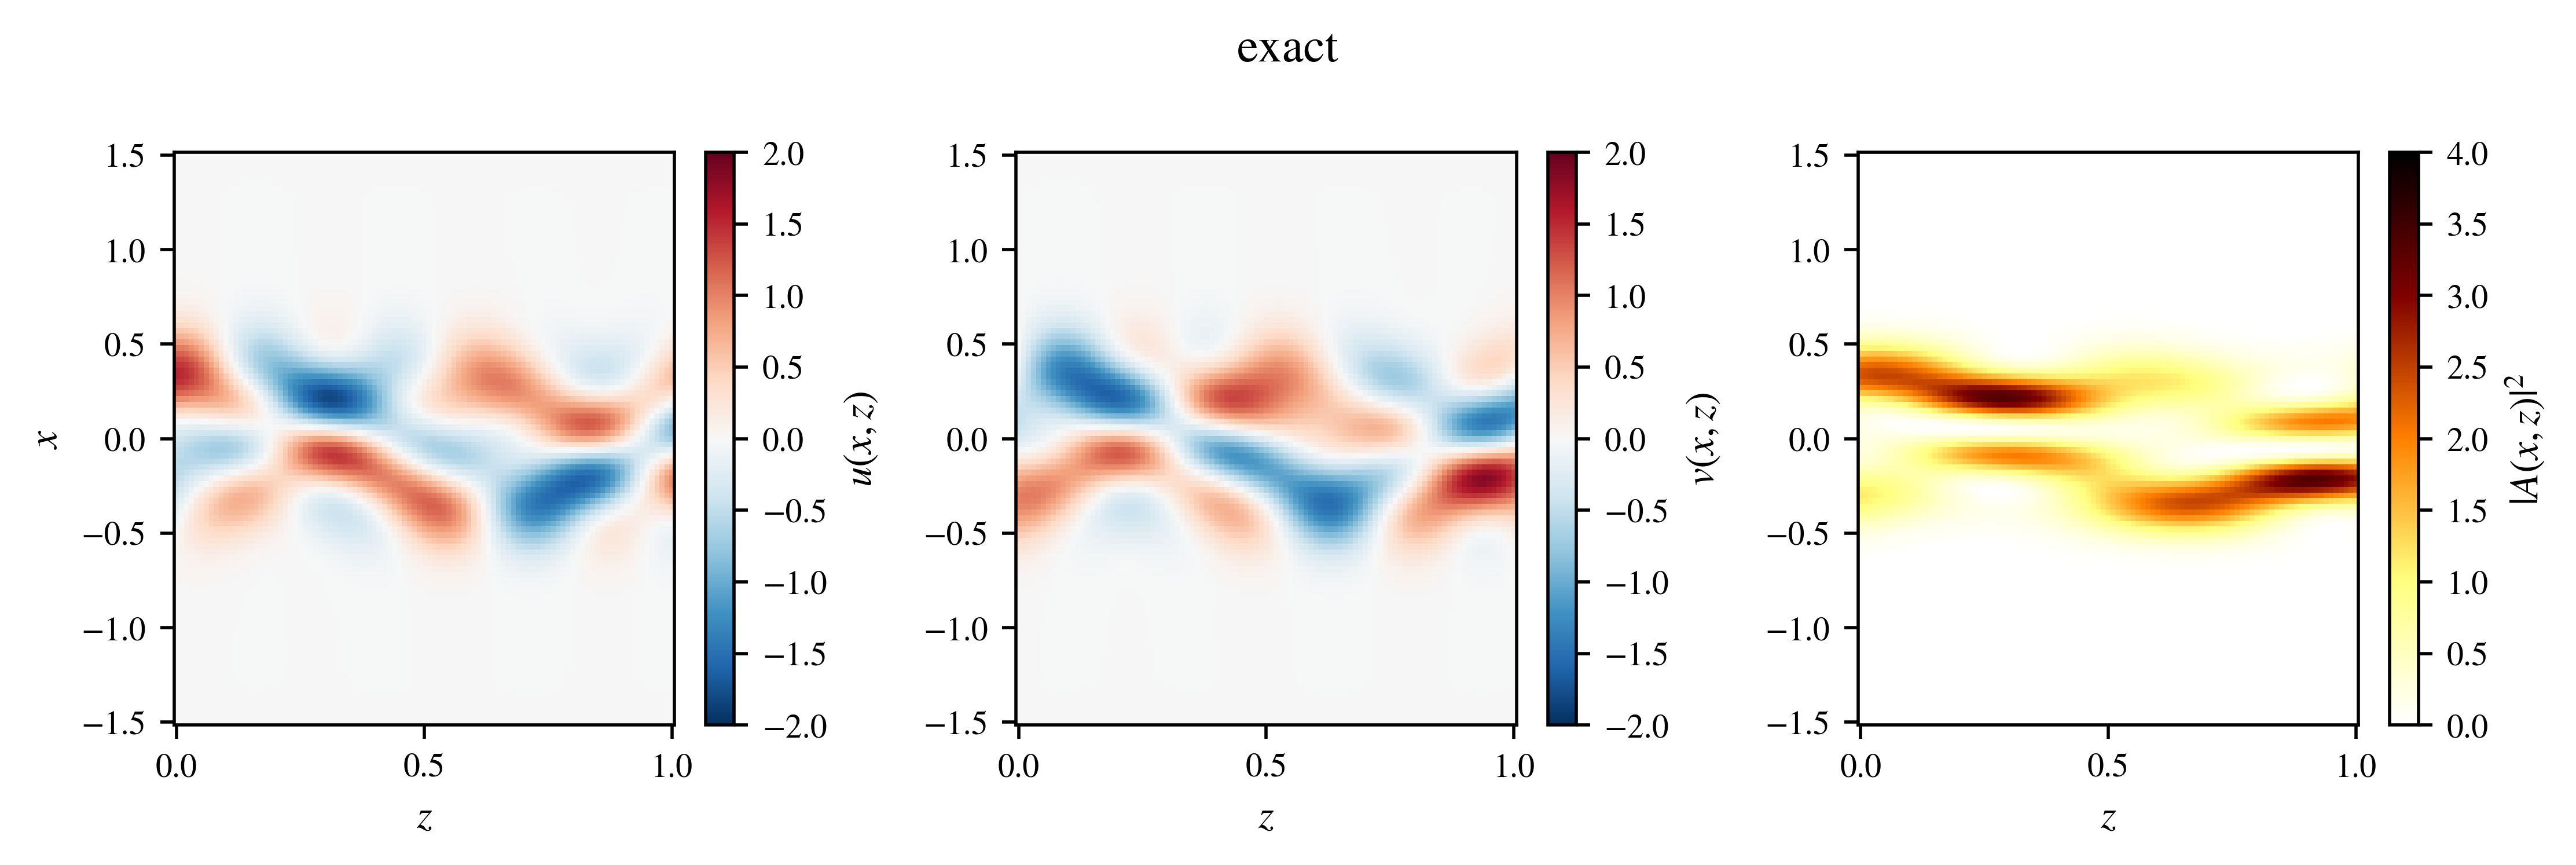

In [67]:
plot_reference()

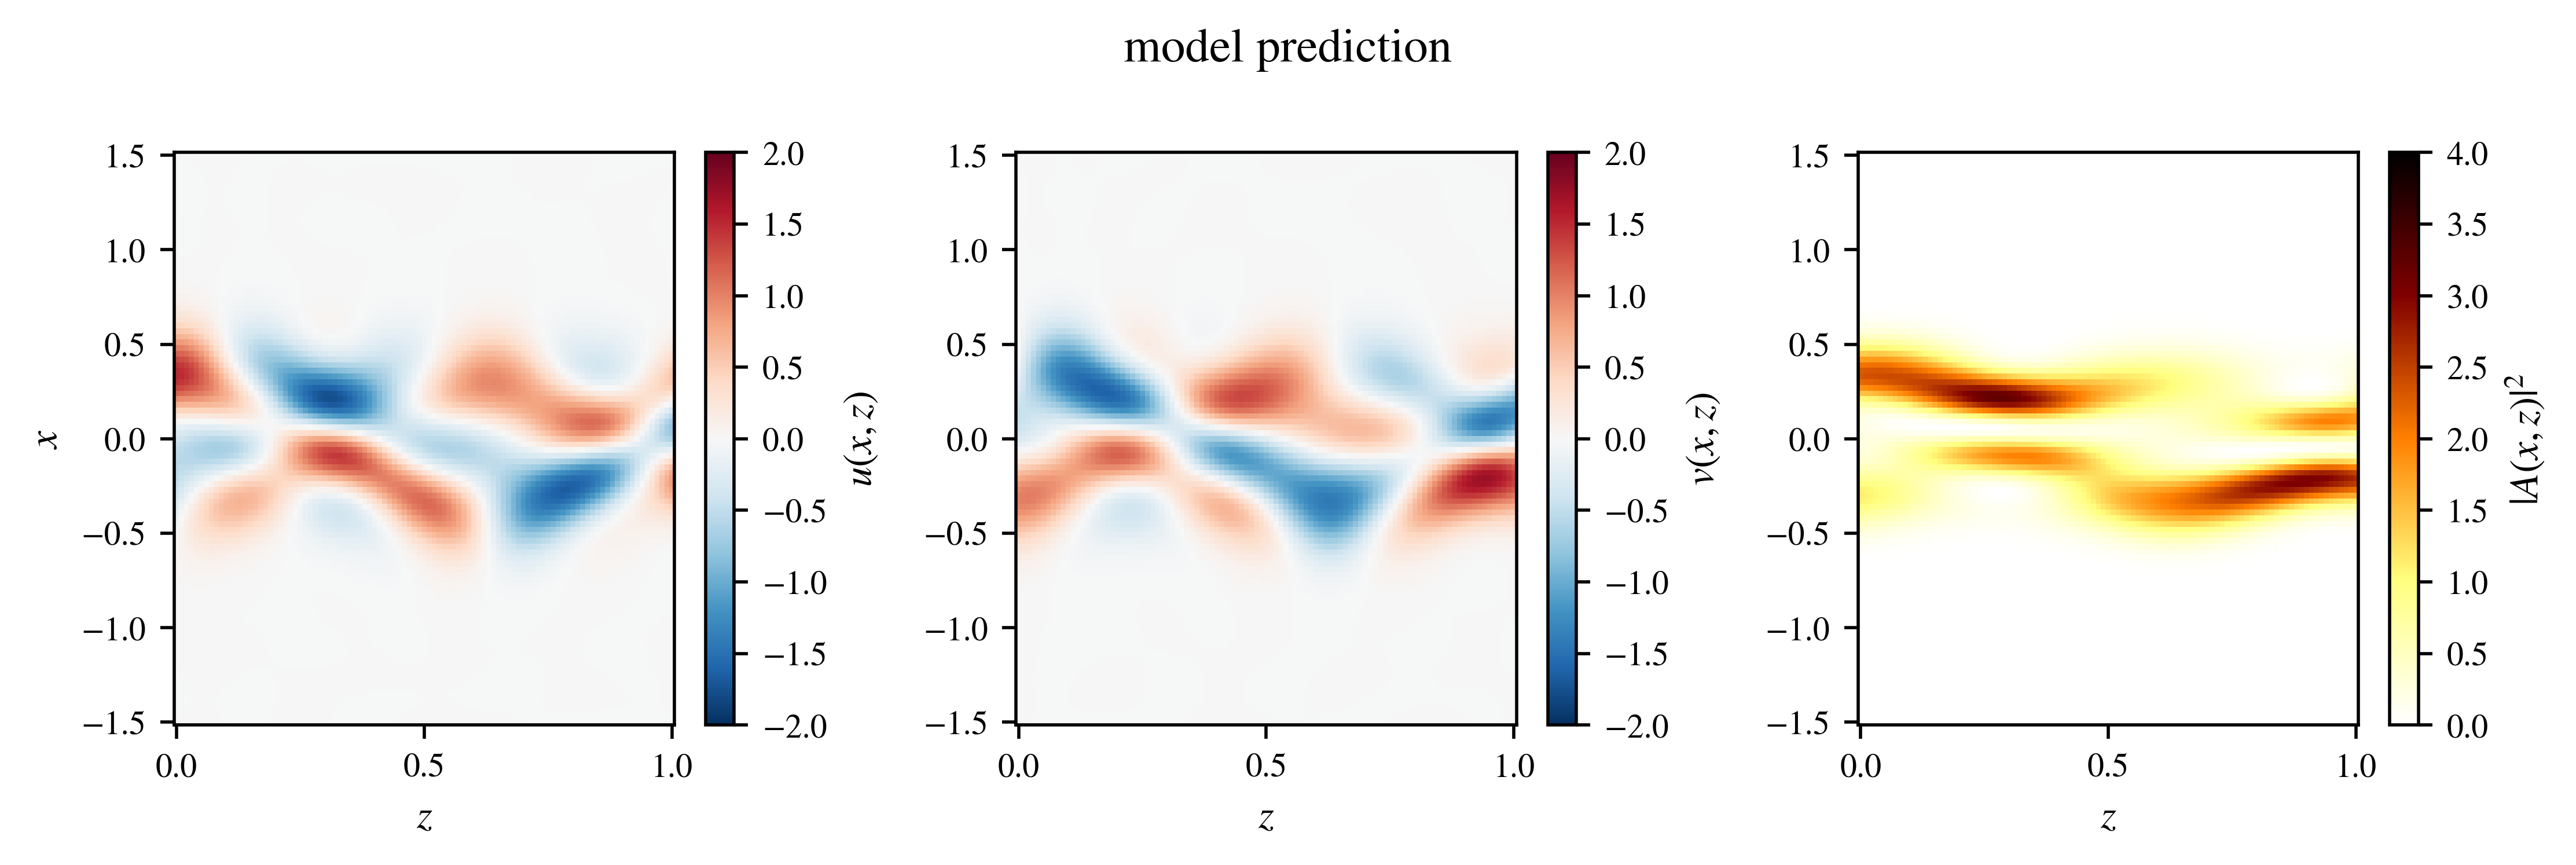

In [68]:
plot_model()

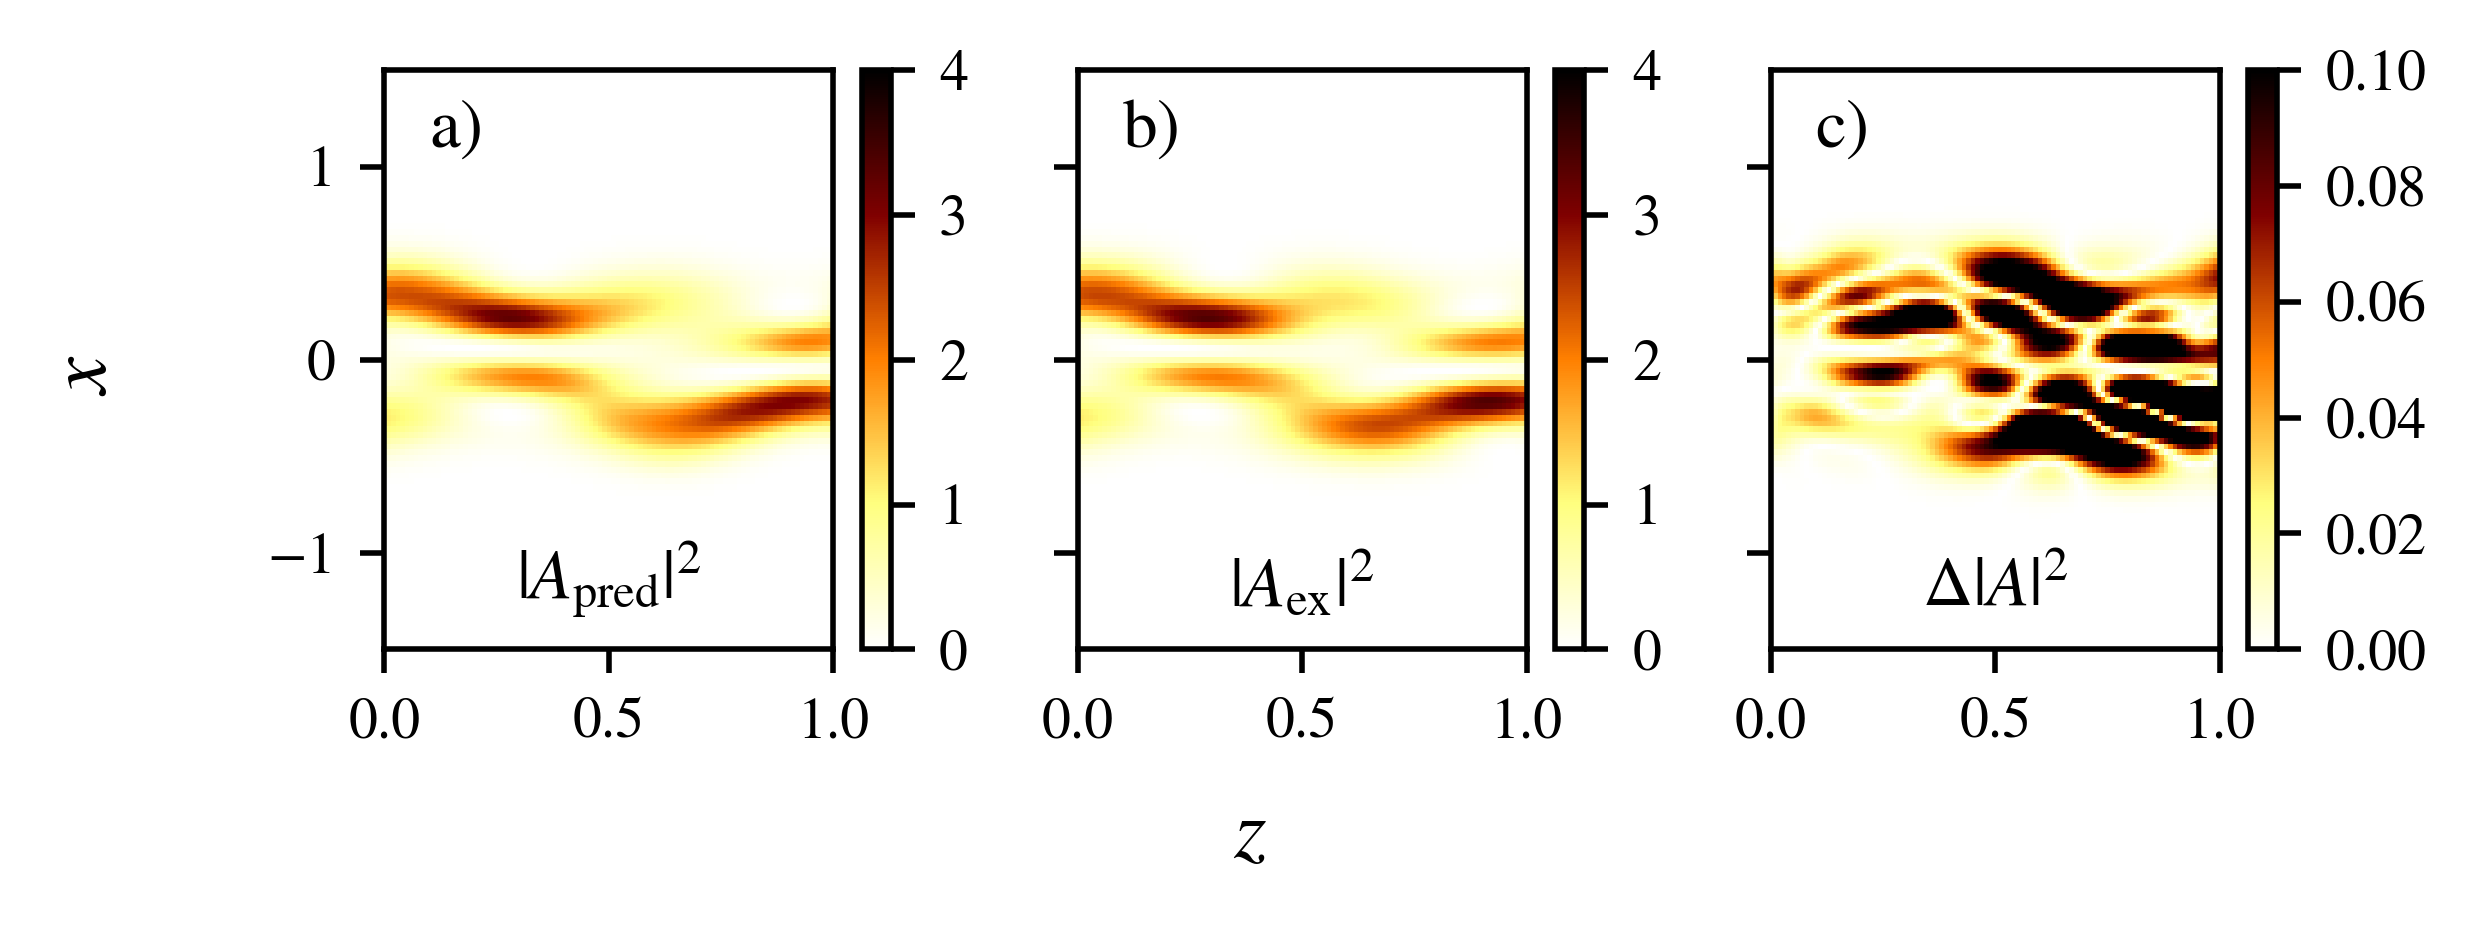

Relative L2 error is  0.07040811


In [69]:
plot_compare_2D()

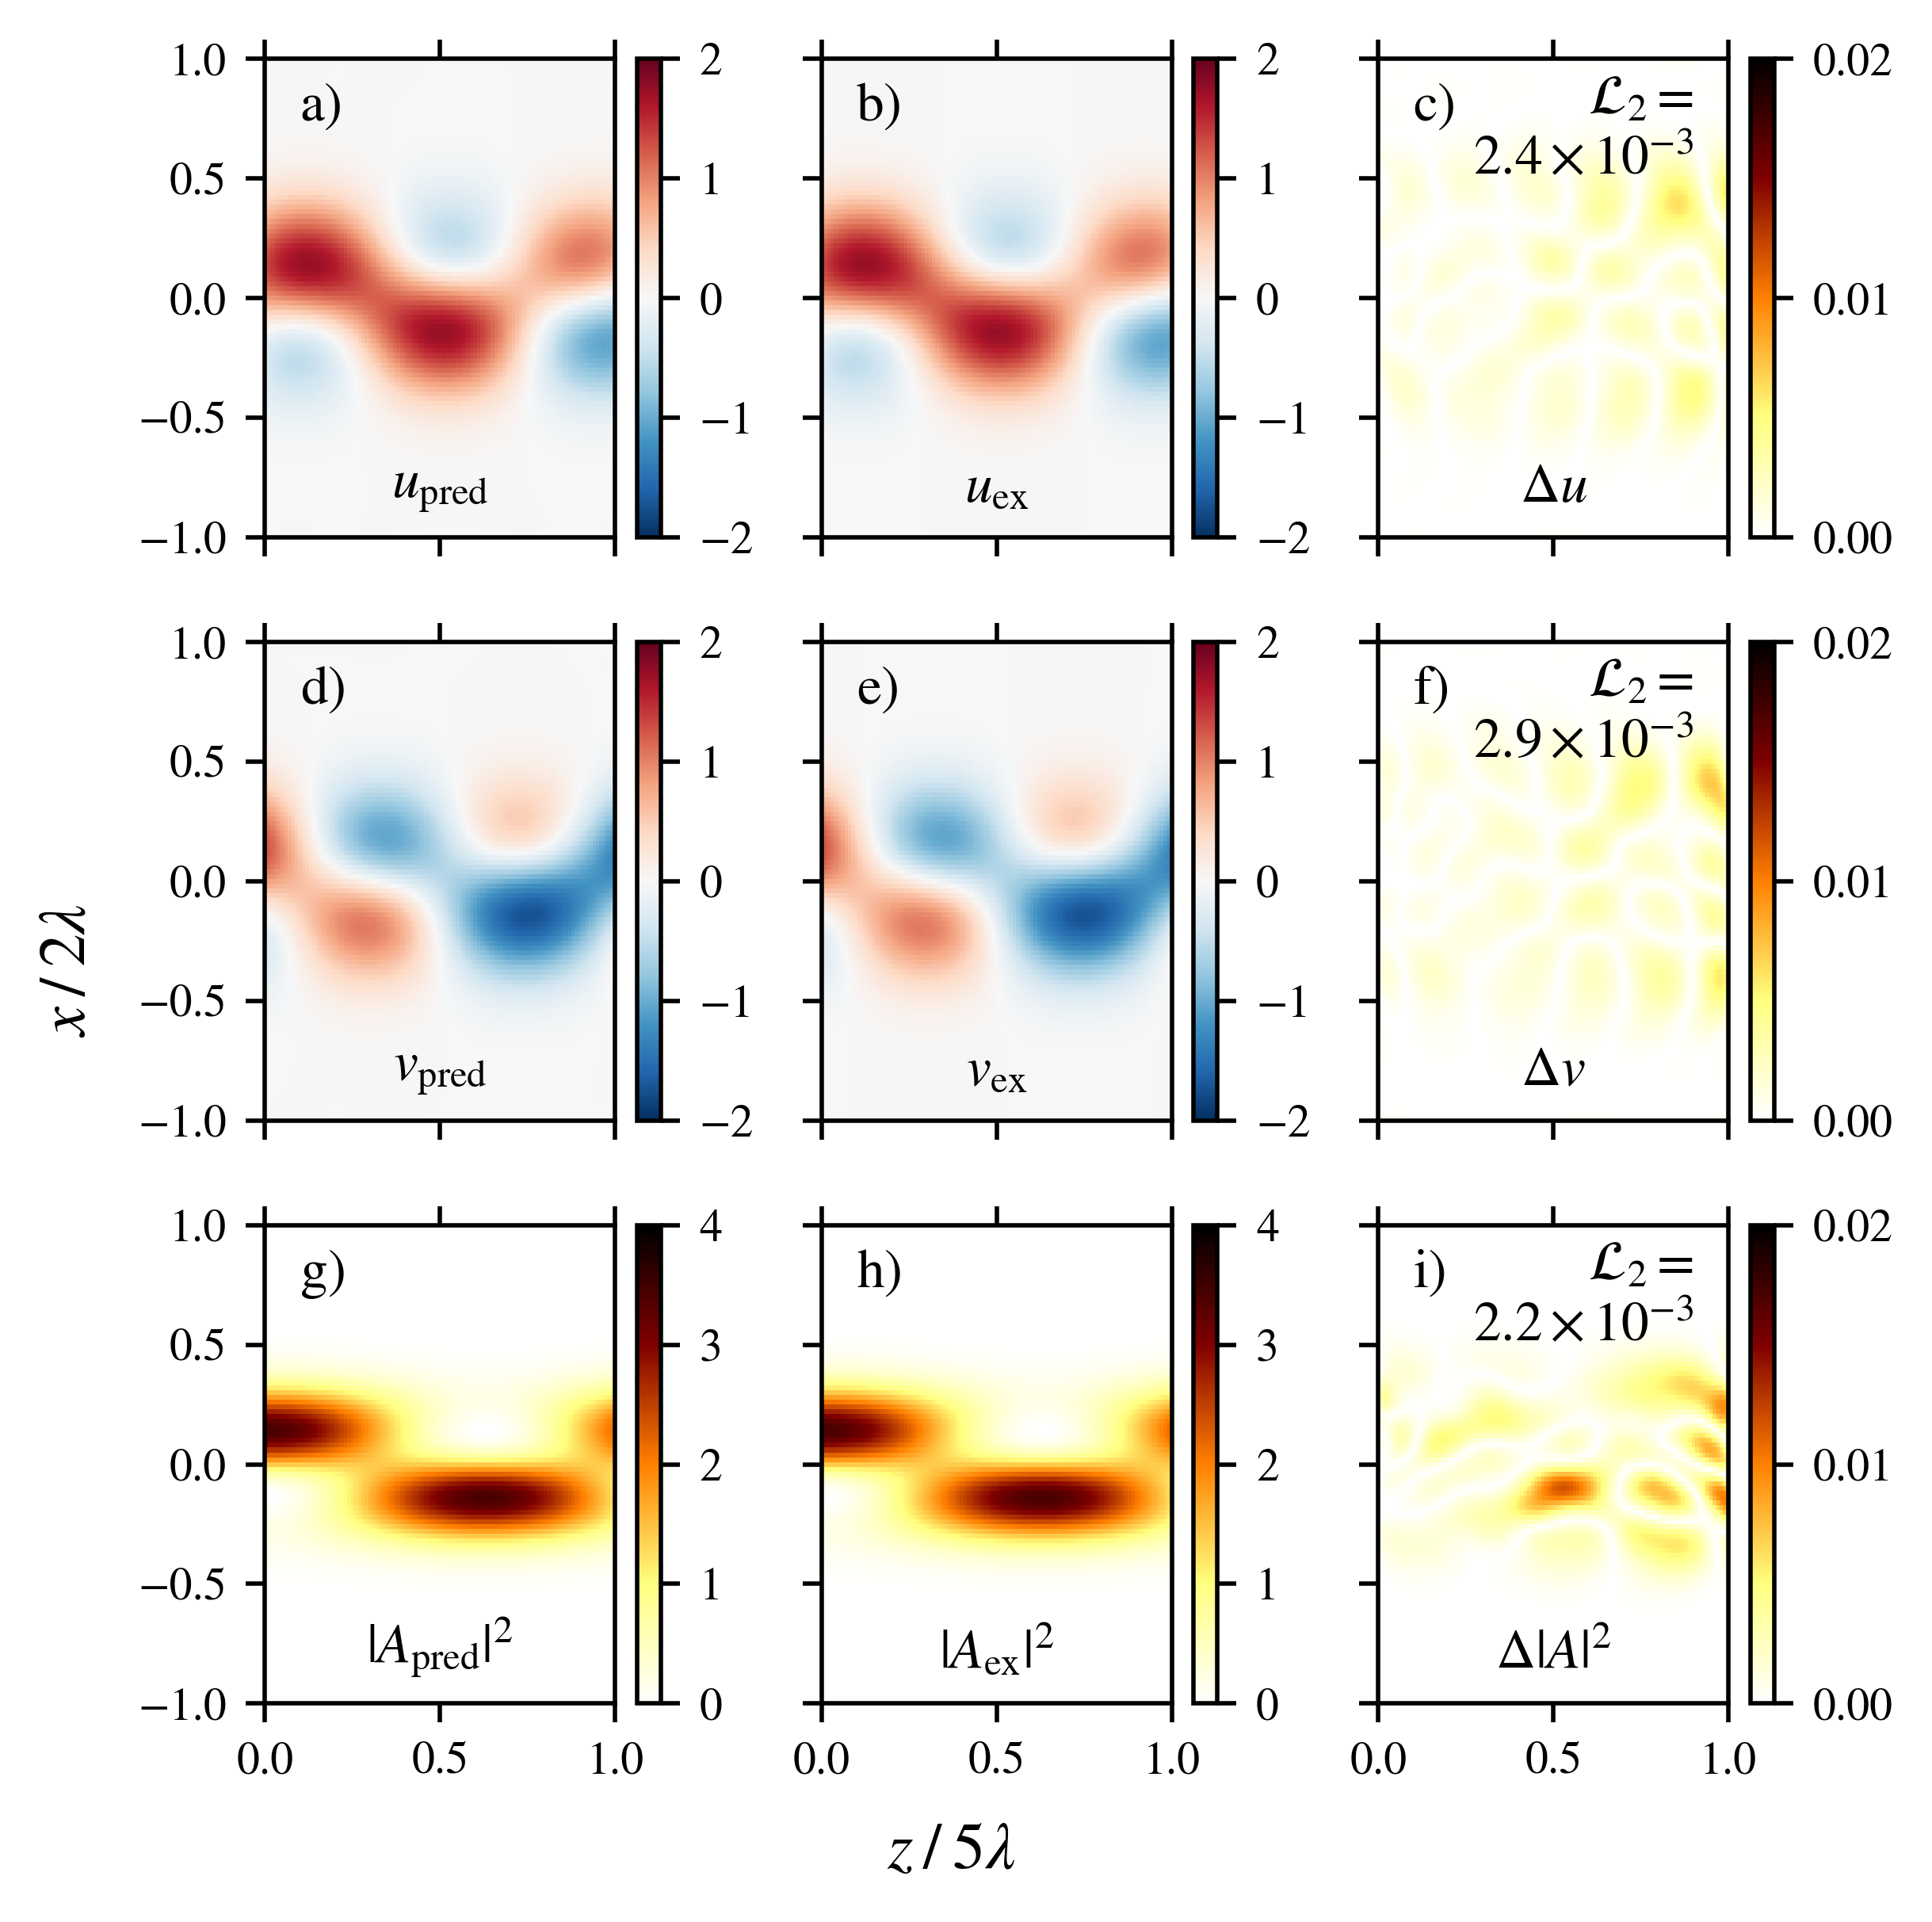

Relative L2 error for u is  0.0024434691 0.0024434691
Relative L2 error for v is  0.0029120666 0.0029120666
Relative L2 error for int is  0.0022133181 0.0022133181


In [36]:
plot_compare_all()

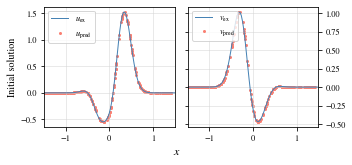

In [71]:
initial_condition_compare()

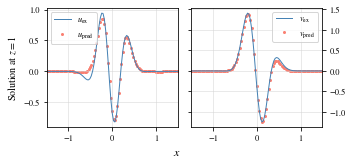

In [72]:
end_solution_compare()

In [47]:
def track_progress2():
    u_comp = u_exact_np(x_np, z_np)
    v_comp = v_exact_np(x_np, z_np)
    iterations = [3000, 8000, 12000, 16000]
    letters = ['a)', 'b)', 'c)', 'd)', 'e)']
    
    fig, axes = plt.subplots(1,5, figsize=(5,2.5), dpi=500)
    
    for i in range(4):
        model.load_weights(f'weights/calc{number}/{iterations[i]}')

        A_plot = model(XZtest)
        u_plot_pre = A_plot[:, 0:1]
        v_plot_pre = A_plot[:, 1:2]

        u_plot = u_plot_pre.numpy().reshape(N_test, N_test)
        v_plot = v_plot_pre.numpy().reshape(N_test, N_test)

        intens = u_plot**2 + v_plot**2
        
        line = axes[i].pcolormesh(ztestm, xtestm, intens, cmap = cm.afmhot_r, vmin=0, vmax=4)#, norm=colors.LogNorm(vmin=1e-2, vmax=1))
        axes[i].text(0.12, -0.9, str(iterations[i]), fontsize=10, verticalalignment='bottom', horizontalalignment='left', bbox=props)
        axes[i].text(0.08, 0.92, letters[i], fontsize=10, verticalalignment='top', horizontalalignment='left')
        axes[i].set_xticks([0, 0.5])
        
        if i != 0:
            axes[i].set_yticklabels([])
            
        axes[i].set_xlim(z_lb, z_ub)
        axes[i].set_ylim(x_lb, x_ub)
        
    fig.subplots_adjust(wspace=0, bottom=.2, top=.96)
    
    line2 = axes[4].pcolormesh(ztestm, xtestm, u_comp**2 + v_comp**2, cmap = cm.afmhot_r, vmin=0, vmax=4)#, norm=colors.LogNorm(vmin=1e-2, vmax=1))
    #cbar = fig.colorbar(line, ax=axes[4])
    cbar = fig.colorbar(line2, ax=axes, location='right')#, pad=2)#, shrink=1.1, aspect=20*0.9, pad=0.2)
    cbar.set_label(r'$|A(x,z)|^2$')
    
    axes[4].text(0.12, -0.9, 'exact', fontsize=10, verticalalignment='bottom', horizontalalignment='left', bbox=props)
    axes[4].set_xticks([0, 0.5, 1])
    axes[4].set_yticklabels([])
    axes[4].set_xlim(z_lb, z_ub)
    axes[4].set_ylim(x_lb, x_ub)
    axes[4].text(0.08, 0.92, letters[4], fontsize=10, verticalalignment='top', horizontalalignment='left')
        
    axes[2].text(0.9, 0.75, 'after\nAdam', fontsize=8, verticalalignment='center', horizontalalignment='right')    
    axes[3].text(0.9, 0.75, 'after\nL-BFGS', fontsize=8, verticalalignment='center', horizontalalignment='right')    
    
    fig.supylabel('$x \: / \: 2\lambda$', fontsize=10)
    axes[2].set_xlabel('$z \: / \: 5\lambda$', fontsize=10)#, y=.005)
    
    #fig.tight_layout()
    fig.subplots_adjust(right=.82)
    
    #fig.savefig(f'{folder}/progress2_calc{number}.png')
    fig.savefig(f'plots/progress2_calc{number}.png')
    plt.show()
    plt.close()

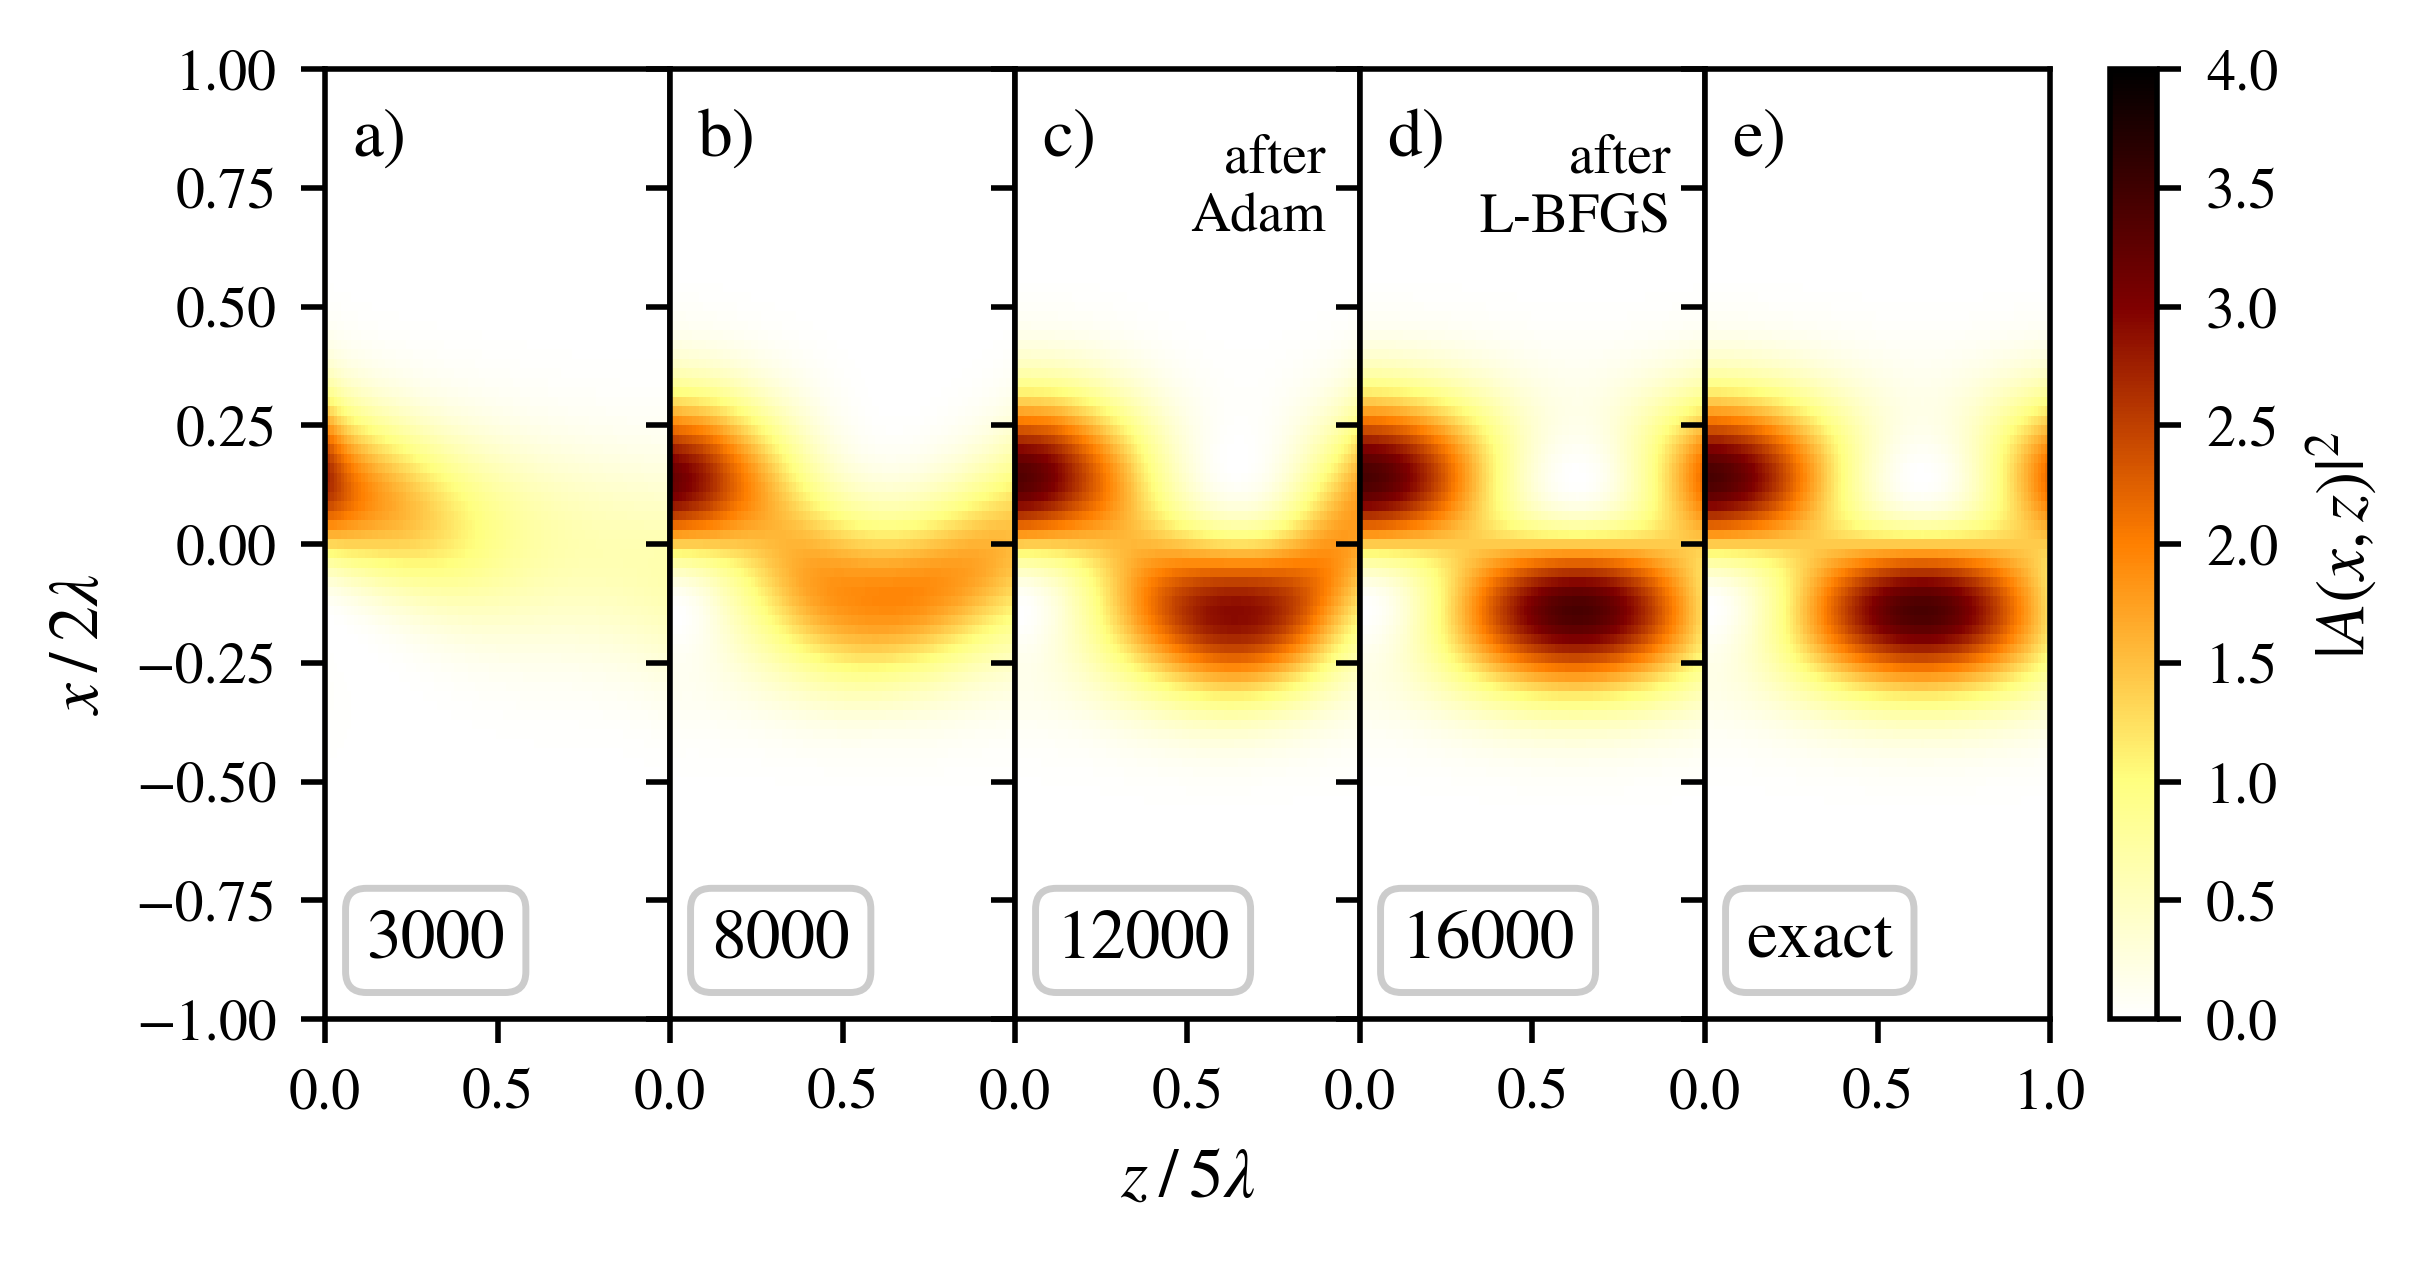

In [48]:
track_progress2()